In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from fxpmath import Fxp

import funcs
import importlib
importlib.reload(funcs)  # Importing the latest version of funcs.py

<module 'funcs' from '/home/urosminoski/Desktop/FAKS/MASTER/All-Digital-RF-Transmitter-in-FPGA-master-/sim/v1.4/python/jupyter/funcs.py'>

In [2]:
def plot_fft(x):
    x_fft = np.fft.fft(x)
    x_fft_dB = 20*np.log10(np.abs(x_fft))
    x_fft_dB -= np.max(x_fft_dB)
    x_fft_dB = x_fft_dB[:len(x)//2]

    freqs = np.linspace(0, 0.5, len(x)//2)

    plt.plot(freqs, x_fft_dB)


In [3]:
# Filter coefficients
b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702]

In [4]:
# Decompos IIR filter to parallel IIR sections
[b_parallel, a_parallel] = funcs.decompose_iir_to_parallel(b, a)

print("Parallel Decomposition:")
for i in range(len(a_parallel)):
    print("Section " + str(i+1) + ":")
    print("\tb =", b_parallel[i])
    print("\ta =", a_parallel[i], "\n")

Parallel Decomposition:
Section 1:
	b = [7.376738447284568]
	a = [1, -0.3466037644977315] 

Section 2:
	b = [0.42386913756811406, -2.782525031028174]
	a = [1, -0.6659138380831608, 0.1626025786310818] 

Section 3:
	b = [-4.606777844852687, 0.023283687418655274]
	a = [1, -0.623802437419108, 0.45098689983844903] 



16.0


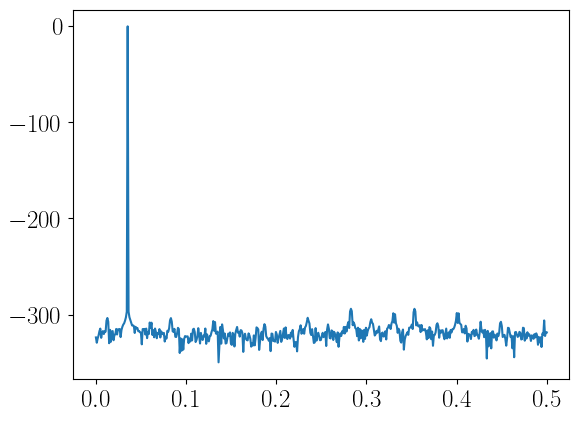

In [5]:
N = 1024
M = 4
OSR = 8
ORD = 5
x = 2**(ORD-1)*np.sin(2*np.pi*np.floor(2/7*N/OSR)*np.arange(N)/N)

plot_fft(x)
print(np.max(x))

In [6]:
b00 = Fxp(b_parallel[0][0], signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around')
a01 = Fxp(a_parallel[0][1], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

b10 = Fxp(b_parallel[1][0], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
b11 = Fxp(b_parallel[1][1], signed=True, n_word=12, n_frac=9, overflow='saturate', rounding='around')
a11 = Fxp(a_parallel[1][1], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a12 = Fxp(a_parallel[1][2], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

b20 = Fxp(b_parallel[2][0], signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around')
b21 = Fxp(b_parallel[2][1], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a21 = Fxp(a_parallel[2][1], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')
a22 = Fxp(a_parallel[2][2], signed=True, n_word=12, n_frac=11, overflow='saturate', rounding='around')

In [7]:
x_fxp = Fxp(0, signed=True, n_word=12, n_frac=7, overflow='saturate', rounding='around')
yi = Fxp(0, signed=True, n_word=12, n_frac=7, overflow='saturate', rounding='around')
e = Fxp(0, signed=True, n_word=12, n_frac=7, overflow='saturate', rounding='around')
v = Fxp(0, signed=True, n_word=5, n_frac=0, overflow='saturate', rounding='around')

y0 = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
y0d = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')

y1 = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w1 = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w1d = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w1dd = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')

y2 = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w2 = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w2d = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')
w2dd = Fxp(0, signed=True, n_word=24, n_frac=19, overflow='saturate', rounding='around')

yiir = Fxp(0, signed=True, n_word=12, n_frac=7, overflow='saturate', rounding='around')

In [8]:
y = np.zeros(len(x))
ee = np.zeros(len(x))

for n in range(len(x)):

    x_fxp( x[n] )
    yi( (yiir+x_fxp)() )
    v( yi() )
    e( (yi-v)() )

    y0( (b00*e + a01*y0d)() )

    w1( (e - a11*w1d - a12*w1dd)() )
    y1( (b10*w1 + b11*w1d)() )

    w2( (e - a21*w1d - a22*w2dd)() )
    y2( (b20*w1 + b21*w2d)() )

    yiir( (y0+y1+y2)() )

    y0d( y0() )
    w2dd( w2d() )
    w2d( w2() )
    w1dd( w1d() )
    w1d( w1() )

    y[n] = v()
    ee[n] = e()

15.0


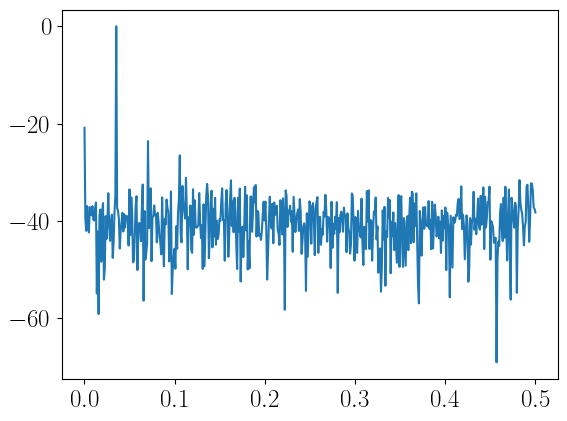

In [9]:
plot_fft(y)
print(np.max(y))

15.9921875


/tmp/ipykernel_4023/3996391994.py:3: RuntimeWarning: divide by zero encountered in log10
  x_fft_dB = 20*np.log10(np.abs(x_fft))


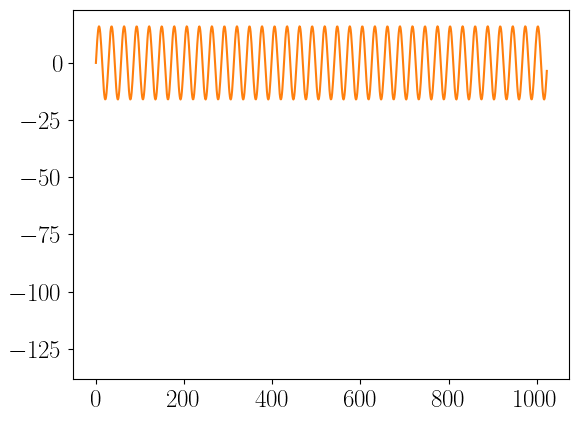

In [10]:
x_ = [Fxp(val, signed=True, n_word=12, n_frac=7, overflow='saturate', rounding='around') for val in x]

plot_fft(x_)
print(np.max(x_))
plt.plot(x_)

0.9921875


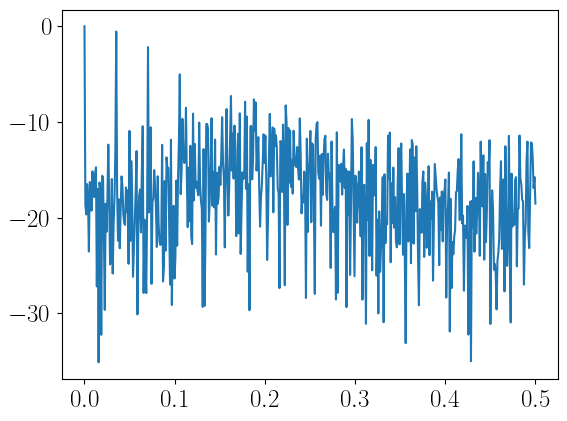

In [11]:
plot_fft(ee)
print(np.max(ee))

In [12]:
g = Fxp(1.25, signed=True, n_word=4, n_frac=2, overflow='saturate', rounding='around')

print(g.info(verbose=3))

	dtype		=	fxp-s4/2
	Value		=	1.25

	Signed		=	True
	Word bits	=	4
	Fract bits	=	2
	Int bits	=	1
	Val data type	=	<class 'float'>

	Upper		=	1.75
	Lower		=	-2.0
	Precision	=	0.25
	Overflow	=	saturate
	Rounding	=	around
	Shifting	=	expand

None
